<a href="https://colab.research.google.com/github/kopalgarg/time-series-forecasting/blob/main/wesad_swell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [567]:

import numpy as np
from numpy import array
from numpy import hstack
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import datetime
import torch
import torch.nn as nn
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta 
from sklearn.preprocessing import MinMaxScaler

In [568]:
if torch.cuda.is_available():
  device = "cuda"
else: device= "cpu"

device

'cuda'

In [664]:
df = pd.read_csv('swell_11.csv')
#Create date index
from datetime import datetime
df['date'] = pd.date_range(start='1/1/2020', periods=len(df), freq='D')
date_time = pd.to_datetime(df.pop('date'), format='%d.%m.%Y')
df=df.drop(['Unnamed: 0', 'subject id', 'SSSQ'], axis=1)
df = df[['HR','RMSSD', 'LF', 'HF','condition']]
df

,HR,RMSSD,LF,HF,condition
0,73.767514,17.208756,1777.401784,14.148344,0
1,124.928711,4.883380,166.127559,13.424803,1
2,126.618429,4.341479,110.313307,7.290439,1
3,124.601777,5.009157,166.452767,11.914737,1
4,73.855344,17.859725,1839.130757,15.646837,0
...,...,...,...,...,...
2784,126.420016,5.268705,269.330622,12.546953,1
2785,76.736734,13.662205,1132.450551,21.122429,0
2786,126.791766,4.807284,135.222522,7.675074,1
2787,75.999227,15.773007,1607.438608,20.352079,0


In [665]:
#scaler = MinMaxScaler()
#dfn = df
#dfn[dfn.columns.difference(['condition'])] = scaler.fit_transform(dfn[dfn.columns.difference(['condition'])])

from sklearn.model_selection import train_test_split

test_ratio = 0.2

y = df['condition']
X=df.drop(['condition'], axis=1)

val_ratio = test_ratio / (1 - test_ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)

In [666]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_arr = scaler.fit_transform(X_train)
X_val_arr = scaler.transform(X_val)
X_test_arr = scaler.transform(X_test)

y_train_arr = y_train.to_numpy()
y_val_arr = y_val.to_numpy()
y_test_arr = y_test.to_numpy()


In [667]:
X_train_arr.shape

(1673, 4)

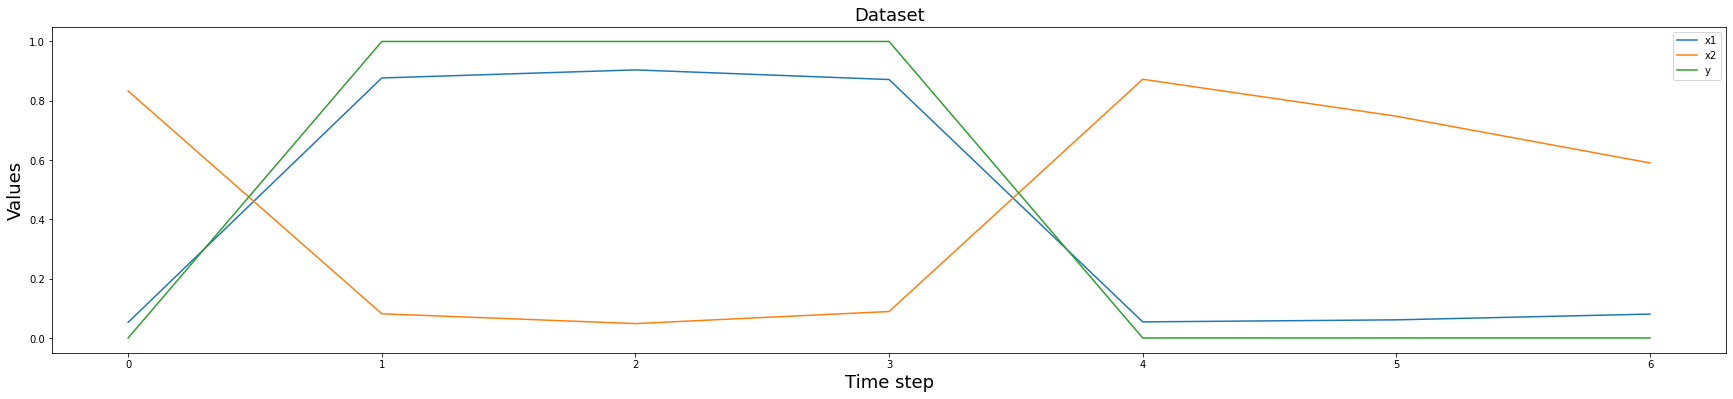

In [669]:
x_1 = X_train_arr[0:7,0]
x_2 = X_train_arr[0:7,1]
y = y_train_arr[0:7]
plt.figure(figsize=(30, 6))
plt.plot(x_1[:7] , label='x1')
plt.plot(x_2[:7] , label='x2')
plt.plot(y[:7] , label='y')
plt.legend(loc='upper right')
plt.title("Dataset" ,  fontsize=18)
plt.xlabel('Time step' ,  fontsize=18)
plt.ylabel('Values' , fontsize=18)
plt.legend()
plt.show()

In [670]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 24

train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)

train_features.to(device)
train_targets.to(device)
val_features.to(device)
val_targets.to(device)
test_features.to(device)
test_targets.to(device)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

In [671]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim,device=x.device).requires_grad_()
        h0.to(device)
        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim,device=x.device).requires_grad_()
        c0.to(device)
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [672]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # GRU layers
        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim,device=x.device).requires_grad_()
        h0.to(device)
        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [673]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(RNNModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim,device=x.device).requires_grad_()
        h0.to(device)

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [674]:
def get_model(model, model_params):
    models = {
        "rnn": RNNModel,
        "lstm": LSTMModel,
        "gru": GRUModel,
    }
    return models.get(model.lower())(**model_params)

In [675]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
    
    def train_step(self, x, y):
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)
        yhat.to(device)
        # Computes loss
        loss = self.loss_fn(y, yhat)
        loss.to(device)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()
    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
        model_path = f'{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'
        if torch.cuda.is_available():
          device = "cuda"
        else: device= "cpu"
        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        torch.save(self.model.state_dict(), model_path)


    def evaluate(self, test_loader, batch_size=1, n_features=1):
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.to('cpu').detach().numpy())
                values.append(y_test.to('cpu').detach().numpy())

        return predictions, values
    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning:

Using a target size (torch.Size([24, 1])) that is different to the input size (torch.Size([24])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



[1/50] Training loss: 0.6370	 Validation loss: 0.4802
[2/50] Training loss: 0.3677	 Validation loss: 0.2982
[3/50] Training loss: 0.2744	 Validation loss: 0.2547
[4/50] Training loss: 0.2577	 Validation loss: 0.2502
[5/50] Training loss: 0.2556	 Validation loss: 0.2499
[6/50] Training loss: 0.2558	 Validation loss: 0.2499
[7/50] Training loss: 0.2545	 Validation loss: 0.2497
[8/50] Training loss: 0.2537	 Validation loss: 0.2498
[9/50] Training loss: 0.2534	 Validation loss: 0.2498
[10/50] Training loss: 0.2533	 Validation loss: 0.2498
[50/50] Training loss: 0.2503	 Validation loss: 0.2500


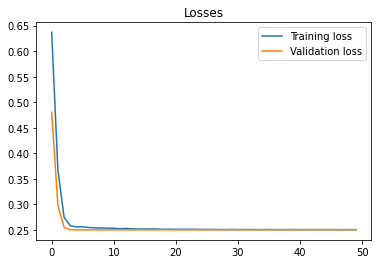

In [714]:
import torch.optim as optim

input_dim = len(X_train.columns)
output_dim = 1
hidden_dim = 4
layer_dim = 3
batch_size = 24
dropout = 0.2
n_epochs = 50
learning_rate = 1e-3
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = get_model('rnn', model_params)

loss_fn = nn.MSELoss(reduction="mean")
loss_fn.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model.to(device), loss_fn=loss_fn.to(device), optimizer=optimizer)

opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)

opt.plot_losses()

In [717]:
predictions, values = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

In [718]:
def inverse_transform(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df


def format_predictions(predictions, values, df_test, scaler):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_result = pd.DataFrame(data={"condition": vals, "prediction": preds}, index=df_test.head(len(vals)).index)
    df_result = df_result.sort_index()
    #df_result = inverse_transform(scaler, df_result, [["condition", "prediction"]])
    return df_result


df_result = format_predictions(predictions, values, X_test, scaler)

In [719]:
#df_result.loc[df_result['prediction'] >= 0.9, 'prediction'] = 1
#df_result.loc[df_result['prediction'] < 0.9, 'prediction'] = 0
df_result

,condition,prediction
2231,0.0,0.496152
2232,1.0,0.498722
2233,0.0,0.495292
2234,1.0,0.498673
2235,1.0,0.498602
...,...,...
2784,1.0,0.498652
2785,0.0,0.495656
2786,1.0,0.498798
2787,0.0,0.495153


In [720]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(df):
    return {'mae' : mean_absolute_error(df.condition, df.prediction),
            'rmse' : mean_squared_error(df.condition, df.prediction) ** 0.5,
            'r2' : r2_score(df.condition, df.prediction)}

result_metrics = calculate_metrics(df_result)
result_metrics

{'mae': 0.49843845, 'r2': 0.0020455828693013434, 'rmse': 0.49844773560062355}

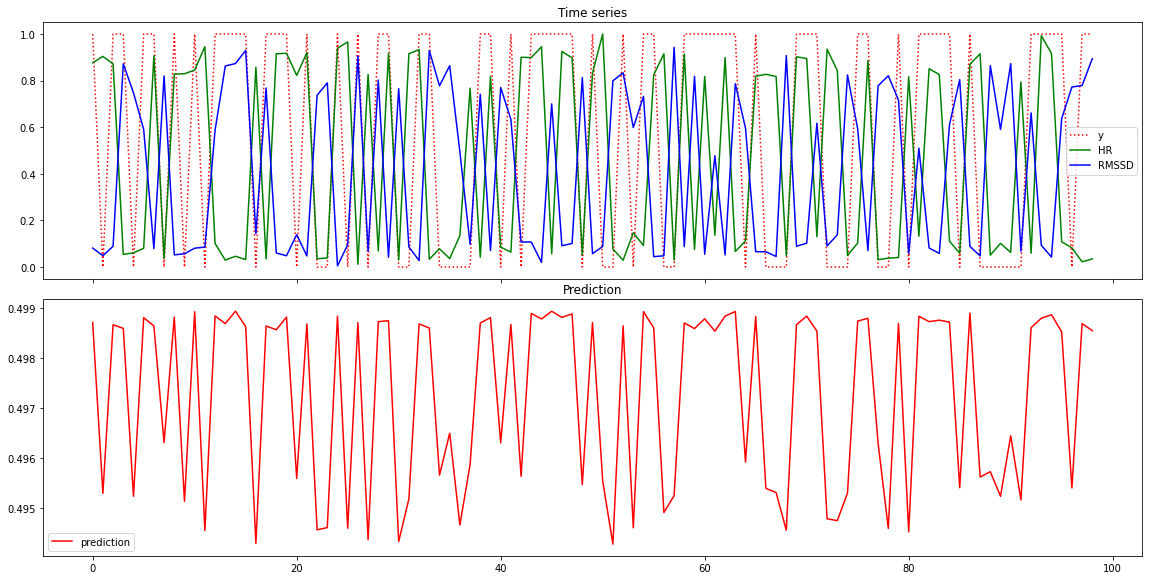

In [756]:
f, (ax1, ax2) = plt.subplots(2, 1 ,sharex='col')
f.set_figheight(8)
f.set_figwidth(16)
f.tight_layout()

ax2.plot(df_result['prediction'][1:100,].values, color = 'red', label='prediction')
ax2.set_title('Prediction')
ax1.plot(df_result['condition'][1:100,].values, color = 'red', linestyle = 'dotted', label = 'y')
ax1.plot(X_train_arr[1:100,0], color ='green',label ='HR')
ax1.plot(X_train_arr[1:100,1], color = 'blue',label ='RMSSD')
ax1.set_title('Time series')
ax1.legend();
ax2.legend();

In [ ]:
# alternatively

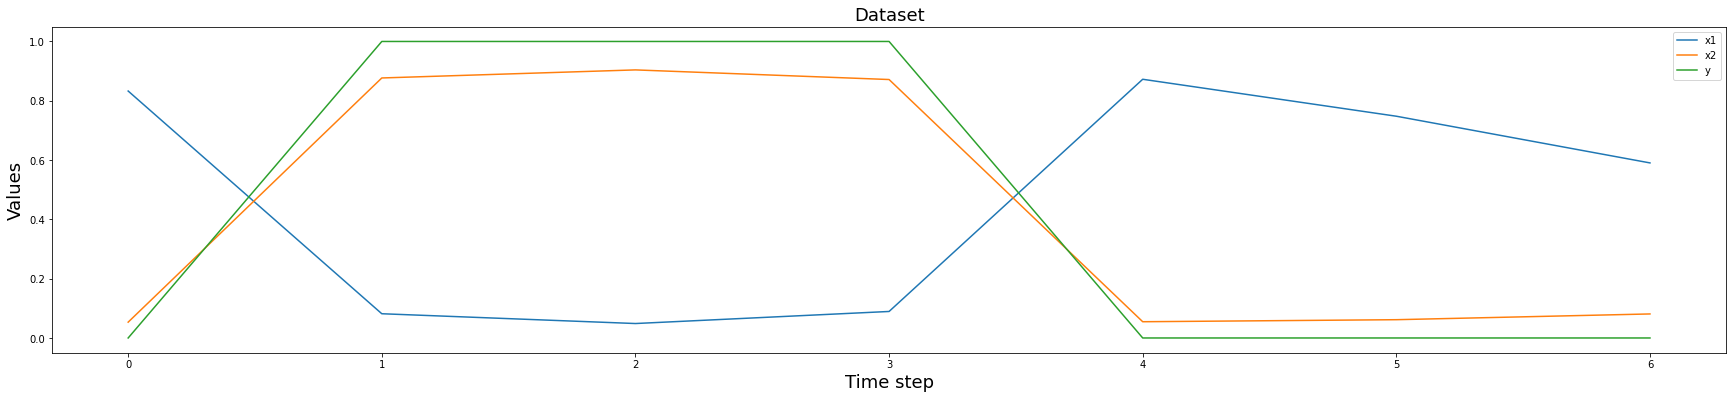

In [284]:
x_1 = df['RMSSD']
x_2 = df['HR']
y = df['condition']
x_1 = x_1.values
x_2 = x_2.values
y = y.values
plt.figure(figsize=(30, 6))
plt.plot(x_1[:7] , label='x1')
plt.plot(x_2[:7] , label='x2')
plt.plot(y[:7] , label='y')
plt.legend(loc='upper right')
plt.title("Dataset" ,  fontsize=18)
plt.xlabel('Time step' ,  fontsize=18)
plt.ylabel('Values' , fontsize=18)
plt.legend()
plt.show()

In [271]:
def split_sequence(sequence, n_steps):
  """function that splits a dataset sequence into input data and
  labels"""
  X, Y = [], []
  for i in range(sequence.shape[0]):
    if (i + n_steps) >= sequence.shape[0]:
      break
      # Divide sequence between data (input) and labels (output)
    seq_X= sequence[i: i + n_steps]
    seq_Y = sequence[i + n_steps, -1]
    X.append(seq_X)
    Y.append(seq_Y)
  return np.array(X), np.array(Y)

In [757]:
x_train, y_train = split_sequence(df.values, 7)
print(x_train.shape)
feature_map_mimic = ['f0', 'f1', 'f2']

#x_train = x_train.reshape((2782,157,7))
print(x_train.shape)

(2782, 7, 5)
(2782, 7, 5)


In [273]:
x_train[0,:,0]

array([0.905856  , 0.06807897, 0.05534499, 0.07114059, 0.91560821,
       0.89012622, 0.85398789])

In [294]:
y_train.shape

(2782,)

In [295]:
df.shape

(2789, 157)